## Assignment
Yeah ! Let's start with our actual project. In this assignment we will load the database and do preprocessing tasks.
Ensure you have following packages installed
1. numpy
2. pandas  
( Hope you are familiar with above two modules well )
3. nltk (don't worry, we just need this to remove stopwords while preprocessing)
4. tensorflow
5. keras
6. scikit-learn

In [2]:
'''
Importing essential libraries and functions
'''
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import io
import json
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Loading the IMDB Reviews Dataset

In [3]:
# TODO:
'''
Using pandas load the imdb reviews csv file
Analyse its shape and columns
Check for missing data and remove those rows
'''
df = pd.read_csv("IMDB_Dataset.csv")
df.dropna(inplace = True)
df['review'] = df['review'].str.lower()
print(df.loc[5])

review       probably my all-time favorite movie, a story o...
sentiment                                             positive
Name: 5, dtype: object


## 2. Data Preprocessing

In [4]:
#TODO : Complete the function to preprocess the text data

def preprocessing(sentence):
    # First make the sentence lowercase
    sentence = sentence.lower()
    
    # Remove all html tags from the sentence i.e replace anything between <> with space
    # Hint use Regular Expression i.e. re.sub()
    sentence = re.sub(r'<.*?>'," ",sentence)
    
    
    # Remove all special characters i.e. anything other than alphabets and numbers. Replace them with space
    special = r'[^a-zA-Z0-9\s]'
    sentence = re.sub(special," ",sentence)
    # Remove all single characters i.e. a-z and A-Z and Replace them with space
    single = r'\b[a-zA-Z]\b'
    sentence = re.sub(single," ",sentence)
    # Remove all multiple spaces and replace them with single space
    sentence = re.sub("\s+"," ",sentence)
    # Use the nltk library to remove all stopwords from the sentence
    # stopwords are the words like and, the, is, are etc.
    words = word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    sentence = [word for word in words if word not in stop_words]
    sentence = ' '.join(sentence)

       
    # return the sentence
    return(sentence)


In [5]:
# TODO :
# Call the preprocessing function for each review in the dataframe and
# save the results in a new list of preprocessed_reviews
# This list will be your input to the neural network
# We will call this list as X from now on
df['preprocessed_reviews'] = df['review'].apply(preprocessing)
X = df['preprocessed_reviews'].tolist()


In [6]:

# TODO :
# Convert sentiment column in the dataframe to numbers
# Convert positive to 1 and negative to 0 and store it in numpy array
# We will call this numpy array as y from now on
df['sentiment_number'] = df['sentiment'].map({'positive': 1,'negative': 0})
y = df['sentiment_number'].tolist()

In [7]:
# TODO : Split the data into training and testing (80-20 ratio)
# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 420)

## Preparing embedding layer
Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning model like LSTM**.  
To know more about word embedding you may refer to following video
https://www.youtube.com/watch?v=9S0-OC4LFNo  
#### Tokenize the data

In [8]:
# Initialize the tokenizer
word_tokenizer = Tokenizer()

# TODO: Fit the tokenizer on the training data (X_train)
word_tokenizer.fit_on_texts(X_train)

# TODO: Convert training data to sequences of integers
# Hint: Use texts_to_sequences method
X_train_sequences = word_tokenizer.texts_to_sequences(X_train)

# TODO: Convert test data to sequences of integers
# Hint: Use texts_to_sequences method
X_test_sequences = word_tokenizer.texts_to_sequences(X_test)

# End TODO
# Saving the tokenizer in a json file (Already done for you)
# This will be used later for prediction on data in next assignments
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
# Vocab_length is the number of unique words in our dataset
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92185

#### Padding

In [9]:
# Padding all reviews to be of same length 'maxlen' words
maxlen = 100
# You can try different dimensions like 50, 100, 200 and 300
# and see how the model performs in next week

# TODO: Pad the training data sequences
# Hint: Use pad_sequences with 'post' padding and maxlen=maxlen
X_train_padded = pad_sequences(X_train_sequences,padding = 'post', maxlen = maxlen)

# TODO: Pad the test data sequences
# Hint: Use pad_sequences with 'post' padding and maxlen=maxlen
X_test_padded = pad_sequences(X_test_sequences, padding = 'post', maxlen = maxlen)

#### Glove Embedding

In [10]:
# Initialize an empty dictionary for embeddings
embeddings_dictionary = dict()

# Open the GloVe file (a2_glove.6B.100d.txt) with utf-8 encoding
glove_file = open('glove_embeddings.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

# TODO : Create an embedding matrix where each row corresponds to the index of the
# unique word in the dataset and each column corresponds to the word vector
# in the GloVe embedding 
# So the matrix will have vocab_length rows and maxlen columns
embedding_matrix = np.zeros((vocab_length,100))
for word,index in word_tokenizer.word_index.items():
    if index<vocab_length:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

print("Shape of the embedding matrix :", embedding_matrix.shape)


Shape of the embedding matrix : (92185, 100)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [12]:
model = Sequential()


model.add(Embedding(input_dim=vocab_length, 
                    output_dim=100, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))


model.add(SpatialDropout1D(0.2))
model.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

c:\Users\saart\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,218,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,218,500 (35.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,218,500 (35.17 MB)

In [13]:
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train_padded, 
                    np.array(y_train), 
                    batch_size=64, 
                    epochs=10, 
                    validation_data=(X_test_padded, np.array(y_test)), 
                    verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.6074 - loss: 0.6521 - val_accuracy: 0.5645 - val_loss: 0.6721
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.6866 - loss: 0.5948 - val_accuracy: 0.7978 - val_loss: 0.4645
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7620 - loss: 0.5021 - val_accuracy: 0.8305 - val_loss: 0.4019
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7917 - loss: 0.4508 - val_accuracy: 0.8345 - val_loss: 0.3796
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8071 - loss: 0.4220 - val_accuracy: 0.8481 - val_loss: 0.3457
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.8177 - loss: 0.3990 - val_accuracy: 0.8587 - val_loss: 0.3283
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.8263 - loss: 0.3823 - val_accuracy: 0.8597 - val_loss: 0.3229
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8361 - loss: 0.3679 - 

In [15]:
loss, accuracy = model.evaluate(X_test_padded, np.array(y_test), verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8700 - loss: 0.2933
Test Accuracy: 87.18%


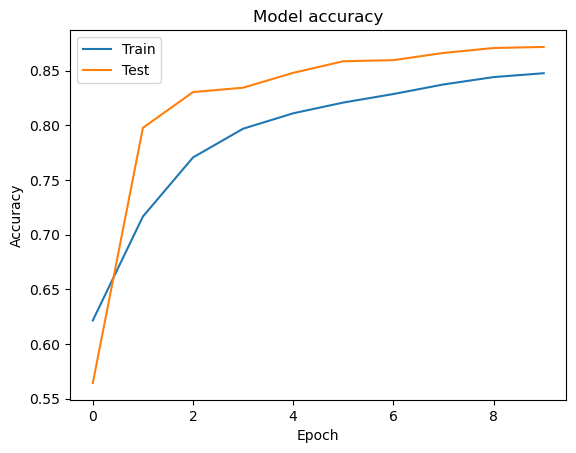

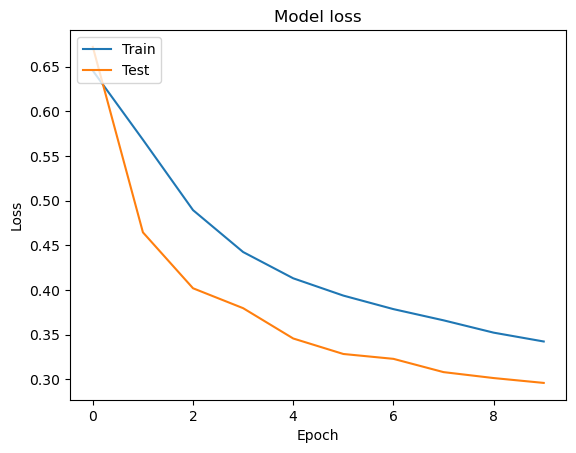

In [16]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
model.save("lstm_imdb_model.keras")


In [19]:
from keras.models import load_model
model = load_model("lstm_imdb_model.keras")


In [20]:
df = pd.read_csv("IMDB_Dataset.csv")
df['preprocessed_reviews'] = df['review'].apply(preprocessing)

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
with io.open('b3_tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)
    tokenizer = Tokenizer(tokenizer_json)

In [24]:
X_sequences = tokenizer.texts_to_sequences(df['preprocessed_reviews'].tolist())
X_padded = pad_sequences(X_sequences, padding='post', maxlen=100)

In [25]:
predictions = model.predict(X_padded)
df['predicted_rating'] = np.round(predictions * 10, 1)
df.to_csv("IMDB_Dataset_with_Predicted_Ratings.csv", index=False)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
